<a href="https://colab.research.google.com/github/jongpal/Image-colorization/blob/main/image_colorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Writing CSV file of Place365
- I used only 300 images for train, 100 images for validation here

In [2]:
# imports
import subprocess
import csv
import os
import numpy as np

import pandas as pd
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torch
from PIL import Image
# import cv2
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR
from torchvision.models import resnet50
from torch.autograd import Variable


In [3]:
# write csv annotation file for train, test data
def get_image_list(file_path):
  os.chdir(file_path)
  # read image name and change it into numpy array
  a = subprocess.run(['ls'], shell=True, check=True, capture_output=True)
  b = a.stdout.decode('utf-8')
  # b.replace(",", )
  b_array = b.split("\n")
  b_array = np.array(b_array[:-1])
  
  return b_array

# path of stored images
file_path = "/content/drive/MyDrive/places365"
 
data = get_image_list(file_path)
file_path = "/content/drive/MyDrive"


def write_csv(image_file_path, from_, to_):
  header = ['image_name']
  # open the file in the write mode
  with open(file_path, 'w') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(header)

    for i in range(from_-1, to_):
      data_ = data[i]
      writer.writerow([data_])

  f.close()


file_path = os.path.join("/content/drive/MyDrive", "places365.csv")
write_csv(file_path, 1, 300)

file_path = os.path.join("/content/drive/MyDrive", "places365_test.csv")
write_csv(file_path, 301, 400)


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Custom Place365 dataset class

In [4]:
class Place365ImageDataset():
  def __init__(self, annotation_csv_file, img_root_dir, is_transfer_model, transform=None):
    """
      Args:
        annotation_csv_file(string) : csv file path where stores annotations, "" if no csv_file
        img_root_dir(string) : directory name with all the images
        transform(callable, optional) : Optional transform applied to samples (e.g. ToTensor(), data augmentation)
    """
    self.annotation_csv = pd.read_csv(annotation_csv_file)
    if self.annotation_csv.shape[1] < 2:
      self.is_label = False
    else:
      self.is_label = True
    self.img_root_dir = img_root_dir   
    # self.is_train = is_train
    self.transform = transform
    self.is_transfer_model = is_transfer_model

  def add_channel_to_gray_image(self, image, ch=0):
    """
      make channel one image to channel 3 
    """
    if torch.is_tensor(image):
      return torch.cat([image, image, image], dim = ch)
    else:
      image = np.concatenate((image, image, image), axis = ch)
      return image

  def __len__(self):
    return len(self.annotation_csv)

  def __getitem__(self, idx):
    """
      assuming first column of csv file is image name, 
      and second column is label of images
      Args:
        idx : index to each of image example
    """
    if torch.is_tensor(idx):
      idx = idx.tolist()

    img_path = os.path.join(self.img_root_dir, self.annotation_csv.iloc[idx, 0])
    
    if ".jpg" in img_path:
      if self.is_transfer_model:
        image = Image.open(img_path)
      else:
        image = read_image(img_path)
      
    else:
      if self.is_transfer_model:
        image = Image.open(img_path + '.jpg')
      else:
        image = read_image(img_path + '.jpg')
    
    # make gray image's channel to 3 (include gray images in training process)
    # for tensor image (torchvision.io.read_image)
    if torch.is_tensor(image):
      if image.shape[0] != 3:
        image = self.add_channel_to_gray_image(image)
    else:
    # for pil image
      np_image = np.array(image)
      if len(np_image.shape) == 2:
        np_image = np.expand_dims(np_image, 2)
      if np_image.shape[2] != 3:
        np_image = self.add_channel_to_gray_image(np_image, 2)
      image = Image.fromarray(np_image)


    if self.transform:
      image = self.transform(image) 

    if self.is_label:
      image_label = self.annotation_csv.iloc[idx, 1]
      return image, image_label
    else:
      return image
    

# Data loader
def get_loader(csv_path, image_path, batch_size, is_transfer_model):

  if is_transfer_model:
    trans = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.2),
                                transforms.ToTensor(),
                                transforms.Resize((224, 224)),                
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]
                              )
  else:
    trans = transforms.Compose([
                                transforms.RandomHorizontalFlip(p=0.2),
                                # transforms.ToTensor(),              
                                # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

  dataset = Place365ImageDataset(csv_path, image_path, is_transfer_model, trans)

  shuffle = True
  data_loader = DataLoader(dataset=dataset,
                           batch_size=batch_size,
                           shuffle=shuffle,
                           num_workers=0)
  

  return data_loader


## Network Models

1. TransferModel
  - using pre-trained resnet50, using the output from conv4_6, replaced first layer to custom one

2. ResidualModel
  - custom model, used encoder & decoder style architecture
  - encoded using ResNet, decoded by referencing earlier layers

In [6]:
model_ = resnet50(pretrained=True)

print(model_)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [16]:
class MyTransferModel(nn.Module):
  def __init__(self):
    super().__init__()

    # (batch, 1, 224, 224) -> (batch, 64, 224, 224)
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False),
    )
    pretrained_ = resnet50(pretrained=True)
  
    # count < 7 : use pretrained parameter until layer2 
    # count < 8 : use pretrained parameter until layer3
    count = 0
    for param in pretrained_.children():
      count += 1
      if count < 8:
        param.requires_grad = False
      else:
        param.requires_grad = True


    self.pretrained = nn.Sequential(*(list(pretrained_.children())[1:3])) # (224, 224, 64) -> (112, 112, 64) 
    self.pretrained_maxpool = nn.Sequential((list(pretrained_.children())[3])) # (112, 112, 64) -> (56, 56, 64) 
    self.pretrained_layer1 = nn.Sequential((list(pretrained_.children())[4])) # (56, 56, 64) -> (56, 56, 256)
    self.pretrained_layer2 = nn.Sequential((list(pretrained_.children())[5])) # (56, 56, 256) -> (28, 28, 512)
    self.pretrained_layer3 = nn.Sequential((list(pretrained_.children())[6])) # (28, 28, 512) -> (14, 14, 1024)
    # self.pretrained_layer4 = nn.Sequential((list(pretrained_.children())[7])) # (14, 14, 1024) -> (7, 7, 2048)

    # (1024, 14, 14) -> (512, 28, 28)
    self.layer2 = nn.Sequential(
        nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2, padding=0, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2)
        )
    # (512, 28, 28) -> (256, 56, 56)
    self.layer3= nn.Sequential(
        nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2, padding=0, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2)
    )
    # (256, 56, 56) -> (64, 112, 112)
    self.layer4= nn.Sequential(
        nn.ConvTranspose2d(256, 64, kernel_size=2, stride=2, padding=0, bias=False),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2)
    )
    # (64, 112, 112) -> (3, 224, 224)
    self.layer5= nn.Sequential(
        nn.ConvTranspose2d(64, 3, kernel_size=2, stride=2, padding=0, bias=False),
        nn.BatchNorm2d(3),
        nn.LeakyReLU(0.2)
    )

    # (3, 224, 224) -> (2, 224, 224)
    # output : Tanh
    self.layer6 = nn.Sequential(
        nn.Conv2d(3, 2, kernel_size=3, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(2),
        nn.Tanh()
    )
    
    
  def forward(self, gray_image):

    # (batch, 1, 224, 224)
    output1 = self.layer1(gray_image)
    output2 = self.pretrained(output1)
    output3 = self.pretrained_maxpool(output2)
    output4 = self.pretrained_layer1(output3)
    output5 = self.pretrained_layer2(output4)
    output6 = self.pretrained_layer3(output5)
    output7 = self.layer2(output6)

    output8 = self.layer3(output7 + output5)
    output9 = self.layer4(output8 + output4)
    output10 = self.layer5(output9 + output1)
    # output10 = self.layer5(output9 + output2)
    # (batch, 2, 224, 224)
    output11 = self.layer6(output10)
    # output11 = self.layer6(output10 + output1)

    return output11
    


In [28]:

class ResidualEncoder(nn.Module):
  def __init__(self):
    super().__init__()

    # (batch, 1, 256, 256) -> (batch, 3, 256, 256)
    self.forward1_conv = nn.Sequential(
        nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(3),
        nn.LeakyReLU(0.2),
    )

    # (3, 256, 256) -> (64, 256, 256) 
    self.forward2_conv = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
    )

    # (64, 256, 256) -> (128, 128, 128)
    self.convolutional_block_64 = nn.Sequential(
        nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 128, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2)
    )
    self.identity_block_64 = nn.Sequential(
        nn.Conv2d(128, 32, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 128, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2)
    )
    self.identity_block_64_2 = nn.Sequential(
        nn.Conv2d(128, 32, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(0.2),
        nn.Conv2d(32, 128, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2)
    )

    # (128, 128, 128) -> (256, 64, 64)
    self.convolutional_block_128 = nn.Sequential(
        nn.Conv2d(128, 64, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 256, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2)
    )
    self.identity_block_128 = nn.Sequential(
        nn.Conv2d(256, 64, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 256, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2)
    )
    self.identity_block_128_2 = nn.Sequential(
        nn.Conv2d(256, 64, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(0.2),
        nn.Conv2d(64, 256, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2)
    )

    # (256, 64, 64) -> (512, 32, 32)  
    self.convolutional_block_256 = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 512, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2)
    )
    self.identity_block_256 = nn.Sequential(
        nn.Conv2d(512, 128, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 512, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2)
    )
    self.identity_block_256_2 = nn.Sequential(
        nn.Conv2d(512, 128, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2),
        nn.Conv2d(128, 512, kernel_size=1, stride=1, padding=0),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2)
    )
    

    # (batch, 512, 32, 32) -> (batch, 256, 32, 32)
    self.forward8_to_backward1 = nn.Conv2d(512, 256, kernel_size=1)

    # ConvTranspose2d stride 2 -> scale out by 2
    self.upscale_32_64 = nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2, padding=0)
    self.upscale_64_128 = nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2, padding=0)
    self.upscale_128_256 = nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, padding=0)
    
    self.backward2_conv = nn.Sequential(
        nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

    self.backward3_conv = nn.Sequential(
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )

    self.backward4_conv = nn.Sequential(
        nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
    )
    self.backward5_conv = nn.Sequential(
        nn.Conv2d(3, 3, kernel_size=3, stride=1, padding=1),
        nn.ReLU()
    )

    self.backward6_conv = nn.Sequential(
        nn.Conv2d(3, 2, kernel_size=1, stride=1, padding=0),
        nn.Tanh()
    )
    self.conv1_bn = nn.BatchNorm2d(3)
    self.conv2_bn = nn.BatchNorm2d(64)
    self.conv3_bn = nn.BatchNorm2d(128)
    self.conv4_bn = nn.BatchNorm2d(256)
    self.conv5_bn = nn.BatchNorm2d(512)

  def forward(self, input_features):
    
    f1 = self.forward1_conv(input_features)
    f2 = self.forward2_conv(f1)

    f3 = self.convolutional_block_64(f2)
    # f3 = self.identity_block_64(f3)
    # f3 = self.identity_block_64_2(f3)

    f4 = self.convolutional_block_128(f3)
    # f4 = self.identity_block_128(f4)
    # f4 = self.identity_block_128_2(f4)

    f5 = self.convolutional_block_256(f4)
    # f5 = self.identity_block_256(f5)
    # f5 = self.identity_block_256_2(f5)

    f6 = self.forward8_to_backward1(self.conv5_bn(f5))
    f7 = self.upscale_32_64(f6)

    b2 = f7 + self.conv4_bn(f4)
    b3 = self.backward2_conv(b2)

    b4 = self.upscale_64_128(b3)

    b5 = self.conv3_bn(f3) + b4
    b6 = self.backward3_conv(b5)

    b7 = self.upscale_128_256(b6)
    b8 = self.conv2_bn(f2) + b7
    b9 = self.backward4_conv(b8)

    b10 = self.conv1_bn(f1) + b9
    b11 = self.backward5_conv(b10)

    b12 = self.backward6_conv(b11)
    b13 = b12 * 127
    # b13 = b12

    return b13


## train

In [48]:
# evaluation metric : psnr 
def psnr(img1, img2):
  mse = torch.mean((img1 - img2) ** 2)
  # mse = (img1 - img2) ** 2 / (img1.shape[0] * img1.shape[1] * img1.shape[2] * img1.shape[3])
  return 20 * torch.log10(255.0 / torch.sqrt(mse))


def tensor2list(input_tensor):
  return input_tensor.cpu().detach().numpy().tolist()

def loss(obj_UV, real_UV):
  """
    calculate loss using euclidean distance between U, V channel
    obj_UV => (m, 2, n_H, n_W), m: batch_size 
    real_UV => (m, 2, n_H, n_W)
  """

  m = obj_UV.shape[0]
  C = obj_UV.shape[1]
  H = obj_UV.shape[2]
  W = obj_UV.shape[3]
  # 1st attempt : naive euclidean distance (next would be blurred Euclidean distance)
  return torch.sqrt(torch.sum(((obj_UV - real_UV) * (obj_UV - real_UV)) ** 2)) / (m * C * H * W)


def rgb_to_yuv(rgb_images):
  """
    tensor
    rgb_images (m, 3, n_H, n_W)
  """
  # if isinstance(type(rgb_images), tuple):
  #   for i in range(len(rgb_images)):


  y = rgb_images[:,0,:,:]*0.299 + rgb_images[:,1,:,:] * 0.587 + rgb_images[:,2,:,:] * 0.114
  u = (rgb_images[:,2,:,:] - y) * 0.564
  v = (rgb_images[:,0,:,:] - y) * 0.713
  
  y = y.unsqueeze(1)
  u = u.unsqueeze(1)
  v = v.unsqueeze(1)

  return torch.cat([y, u, v], dim=1)

def yuv_to_rgb(yuv_images):
  """
    yuv_images (m, 3, n_H, n_W)
  """
  r = yuv_images[:,0,:,:] + yuv_images[:,2,:,:] * 1.402
  g = yuv_images[:,0,:,:] - 0.344 * yuv_images[:,1,:,:] - 0.714*yuv_images[:,2,:,:]
  b = yuv_images[:,0,:,:] + 1.772 * yuv_images[:,1,:,:]

  r = r.unsqueeze(1)
  g = g.unsqueeze(1)
  b = b.unsqueeze(1)

  return torch.cat([r, g, b], dim=1)

# 평가 수행 함수
def _test(model, test_dataloader, is_transfer_model):
  
  model.eval()

  psnr_ = 0
  count = 0
  costs = 0
  with torch.no_grad():

    for (step, batch) in enumerate(test_dataloader):
      c_batch = batch[0].unsqueeze(0).cuda()
  
      for t in range(1, len(batch)):
        t_ = batch[t].unsqueeze(0)
        k = t_.type(torch.FloatTensor).cuda()
        # k = t_.type(torch.FloatTensor).cpu()
        c_batch = torch.cat([c_batch, k], dim=0)

      gt_images = c_batch

      yuv_gt_images = rgb_to_yuv(gt_images)
      gt = yuv_gt_images[:, 1:, :, :] # only U, V

      gray_img = yuv_gt_images[:, 0, :, :] 
      gray_img = gray_img.unsqueeze(1)
      hypothesis = model(gray_img)

      img = torch.cat([gray_img, hypothesis], dim=1)

      img = yuv_to_rgb(img)
      
      gt_img = torch.cat([gray_img, gt], dim=1)
      gt_img = yuv_to_rgb(gt_img)

      img = img.to(gt_img.get_device())

      costs += torch.mean((gt_img - img) ** 2)
      count += 1
      if config["mode"] == "test":
        # reverse normalization
        if is_transfer_model:
          MEAN = torch.tensor([0.485, 0.456, 0.406]).to(gt_img.get_device())
          STD = torch.tensor([0.229, 0.224, 0.225]).to(gt_img.get_device())

          img = img * MEAN[None, :, None, None] + STD[None, :, None, None]
          gt_img = gt_img * MEAN[None, :, None, None] + STD[None, :, None, None]

          gray_img = gray_img * MEAN[0].reshape(1, 1, 1, 1) + STD[0].reshape(1, 1, 1, 1)
          
          img *= 255
          gt_img *= 255
          gray_img *= 255


        psnr_ += psnr(img, gt_img)

        if count % 3 == 0:
          img_ = torch.transpose(img, 1, 3)
          img_ = torch.transpose(img_, 1, 2)
          gt_img_ = torch.transpose(gt_img, 1, 3)
          gt_img_ = torch.transpose(gt_img_, 1, 2)
          gray_img_ = torch.transpose(gray_img, 1, 3)
          gray_img_ = torch.transpose(gray_img_, 1, 2)
          fig = plt.figure()
          ax0 = fig.add_subplot(1, 3, 1)
          ax0.imshow(gray_img_[1].cpu().squeeze(), cmap='gray', vmin=0, vmax=255)
          ax0.set_title("gray")

          ax1 = fig.add_subplot(1, 3, 2)
          ax1.imshow(img_[1].cpu().type(torch.IntTensor), vmin=0, vmax=255)

          ax1.set_title("predicted")
          ax2 = fig.add_subplot(1, 3, 3)
          ax2.imshow(gt_img_[1].type(torch.IntTensor).cpu())
      
          ax2.set_title("ground truth")
          plt.show()
      
    if config["mode"] == "test":
      print(f'testing average PSNR={psnr_/ count}')
    print(f'testing average costs={costs / count}')

    return costs / count

def test(config):
  # model = ResidualEncoder().cuda()

  is_transfer_model = False
  if config["which_network"] == 0:
    model = ResidualEncoder().cuda()
  elif config["which_network"] == 1:
    model = MyTransferModel().cuda()
    is_transfer_model = True

  
  annotation_csv_file = config["annotation_csv_test_file"]
  img_dir = config["img_dir"]
  batch_size = config["batch_size"]

  model.load_state_dict(torch.load(os.path.join(config["output_dir"], config["model_name"])))
  data_loader = get_loader(annotation_csv_file, img_dir, batch_size, is_transfer_model)

  costs = _test(model, data_loader, is_transfer_model)
  return costs

def train(config):
  # torch.cuda.init()
  # torch.cuda.empty_cache()
  is_transfer_model = False
  if config["which_network"] == 0:
    model = ResidualEncoder().cuda()
  elif config["which_network"] == 1:
    model = MyTransferModel().cuda()
    is_transfer_model = True


  

  annotation_csv_file = config["annotation_csv_file"]
  img_dir = config["img_dir"]
  batch_size = config["batch_size"]

  data_loader = get_loader(annotation_csv_file, img_dir, batch_size, is_transfer_model)


  # 1st attempt : calculate distance on U, V space
  loss_func = nn.MSELoss()
  # loss_ = nn.CrossEntropyLoss()

  optimizer = torch.optim.Adam(model.parameters(), betas = (0.9, 0.999), lr=config["learning_rate"])

  StepLR(optimizer, step_size=15, gamma=0.5)

  costs_train = []
  costs_val = []

  for epoch in range(config["epoch"]):

    model.train()

    costs = []

    for (step, batch) in enumerate(data_loader):
      c_batch = batch[0].unsqueeze(0).cuda()
      # c_batch = batch[0].unsqueeze(0).cpu()
      for t in range(1, len(batch)):
        t_ = batch[t].unsqueeze(0)
        # change tensort type to int => float and change it to cuda
        k = t_.type(torch.FloatTensor).cuda()
        # k = t_.type(torch.FloatTensor).cpu()
        c_batch = torch.cat([c_batch, k], dim=0)

      
      gt_images = c_batch
      yuv_gt_images = rgb_to_yuv(gt_images)
      gt = yuv_gt_images[:, 1:, :, :] # only U, V

      gray_img = yuv_gt_images[:, 0, :, :] 
      gray_img = gray_img.unsqueeze(1)

      optimizer.zero_grad()
      hypothesis = model(gray_img)


      cost = loss_func(hypothesis, gt)
      # cost = loss(hypothesis, gt)

      cost.backward()
      optimizer.step()

      costs.append(cost.data.item())

    print("Average Loss= {0:f}".format(np.mean(costs)))
    costs_train.append(np.mean(costs))
    torch.save(model.state_dict(), os.path.join(config["output_dir"], "epoch_{0:d}.pt".format(epoch)))

    config["model_name"] = "epoch_{0:d}.pt".format(epoch)
    costs_val.append(test(config))

    if epoch % 10 == 0:

      img = torch.cat([gray_img, hypothesis], dim=1)
      img = yuv_to_rgb(img)
      
      # plot
      num_to_plot = 4
      perm = torch.randperm(img.shape[0])
      idx = perm[:num_to_plot]
      samples = img[idx] 
      samples = torch.transpose(samples, 1, 3)
      samples = torch.transpose(samples, 1, 2)
      
      gray_img_ = gray_img[idx]
      gray_img_ = torch.transpose(gray_img_, 1, 3)
      gray_img_ = torch.transpose(gray_img_, 1, 2)

      for ind in range(num_to_plot):
        color_img_to_show = samples[ind]
        gray_img_to_show = gray_img_[ind]

        if is_transfer_model:
          MEAN = torch.tensor([0.485, 0.456, 0.406]).to(color_img_to_show.get_device())
          STD = torch.tensor([0.229, 0.224, 0.225]).to(color_img_to_show.get_device())

          # reverse the normalize process
          color_img_to_show = color_img_to_show * STD[None, None, :] + MEAN[None, None, :]
          gray_img_to_show = gray_img_to_show * STD[0].reshape(1, 1, 1) + MEAN[0].reshape(1, 1, 1)

          color_img_to_show *= 255
          gray_img_to_show *= 255

        fig = plt.figure()
        ax1 = fig.add_subplot(2, 3, ind+1)
        ax1.imshow(color_img_to_show.type(torch.IntTensor), vmin=0, vmax=255)
        ax1.set_title("color")
        ax1.axis('off')
        ax2 = fig.add_subplot(2, 3, ind+2)
        ax2.imshow((gray_img_to_show.squeeze()).type(torch.IntTensor), cmap='gray', vmin=0, vmax=255)
        ax2.set_title("gray")
        ax2.axis('off')
      plt.show()

  return costs_train, costs_val
      

## MyTransferModel training / test result

Average Loss= 0.218722


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


testing average costs=0.2026316076517105


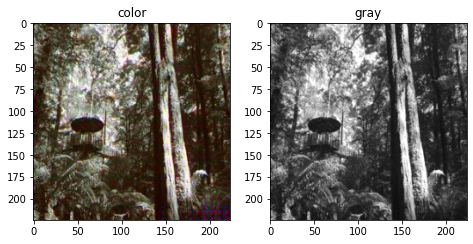

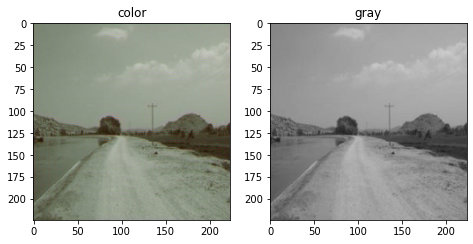

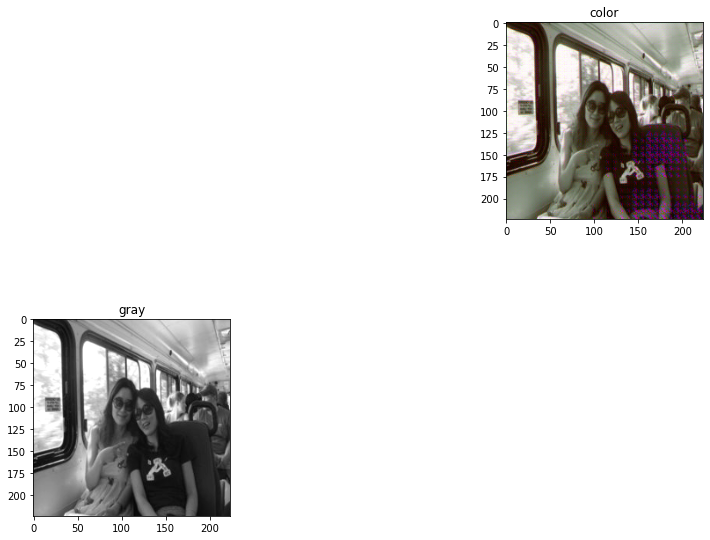

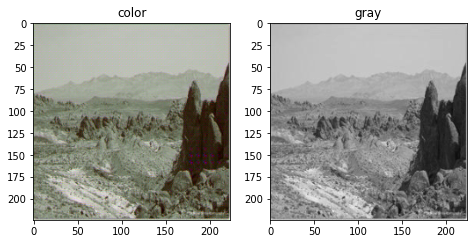

Average Loss= 0.094967
testing average costs=0.15745794773101807
Average Loss= 0.083767
testing average costs=0.15829065442085266
Average Loss= 0.081447
testing average costs=0.15085037052631378
Average Loss= 0.078967
testing average costs=0.1369314044713974
Average Loss= 0.075208
testing average costs=0.16534678637981415
Average Loss= 0.072951
testing average costs=0.13905981183052063
Average Loss= 0.070517
testing average costs=0.12631602585315704
Average Loss= 0.069547
testing average costs=0.12629272043704987
Average Loss= 0.067726
testing average costs=0.12832555174827576
Average Loss= 0.067621


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


testing average costs=0.128043532371521


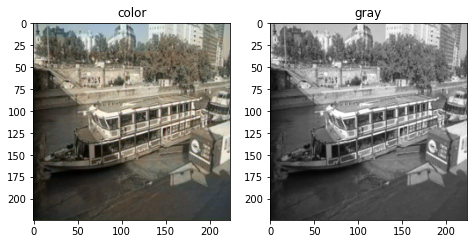

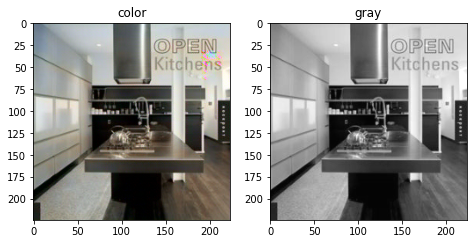

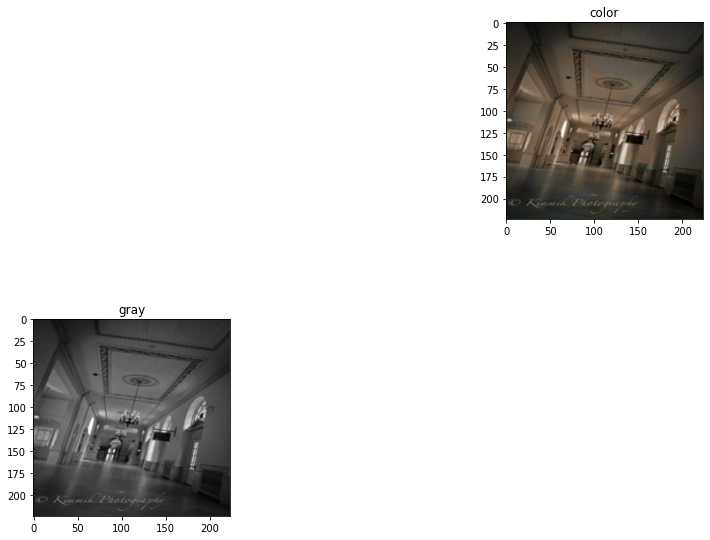

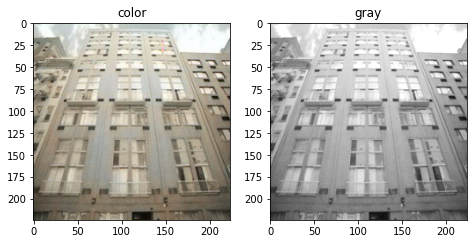

Average Loss= 0.064323
testing average costs=0.13837309181690216
Average Loss= 0.063045
testing average costs=0.12171623110771179
Average Loss= 0.061085
testing average costs=0.12538540363311768
Average Loss= 0.058940
testing average costs=0.1201389878988266
Average Loss= 0.056080
testing average costs=0.12804418802261353
Average Loss= 0.052700
testing average costs=0.12340261787176132
Average Loss= 0.049783
testing average costs=0.12372313439846039
Average Loss= 0.047466
testing average costs=0.12506617605686188
Average Loss= 0.045541
testing average costs=0.12274728715419769
Average Loss= 0.045903


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


testing average costs=0.12345089763402939


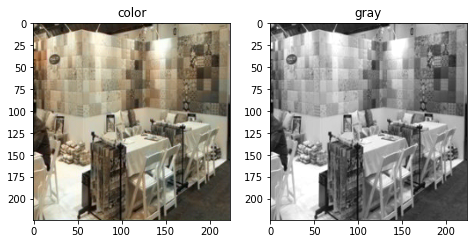

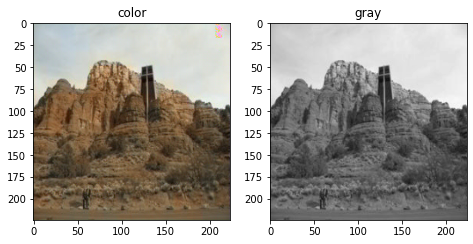

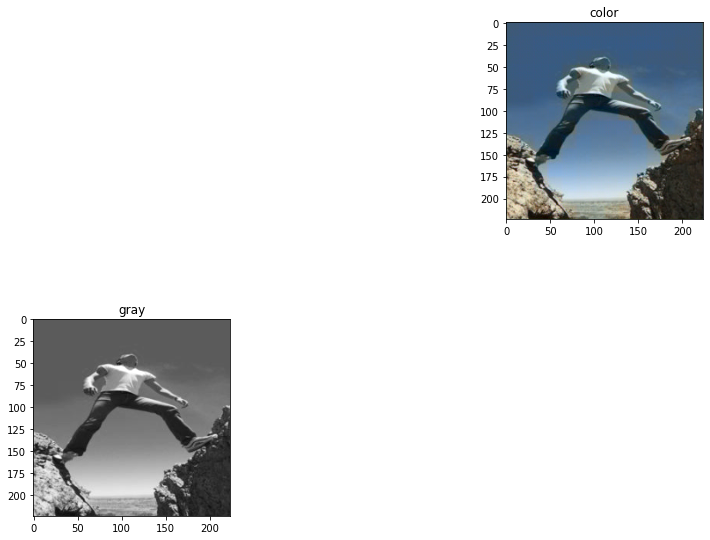

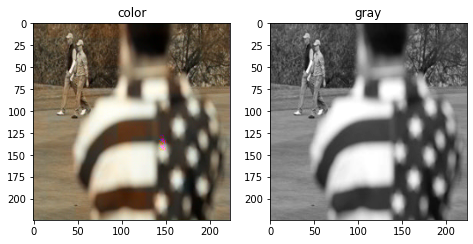

Average Loss= 0.042322
testing average costs=0.1312379390001297
Average Loss= 0.038396
testing average costs=0.12337121367454529
Average Loss= 0.037782
testing average costs=0.1322249472141266
Average Loss= 0.036201
testing average costs=0.13172821700572968
Average Loss= 0.034962
testing average costs=0.13810336589813232
Average Loss= 0.034735
testing average costs=0.12274263054132462
Average Loss= 0.036817
testing average costs=0.12001936882734299
Average Loss= 0.039254
testing average costs=0.13140735030174255
Average Loss= 0.037281
testing average costs=0.12563006579875946
Average Loss= 0.035118


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


testing average costs=0.12366927415132523


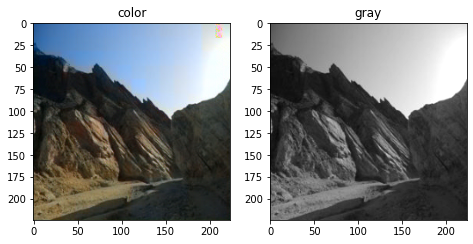

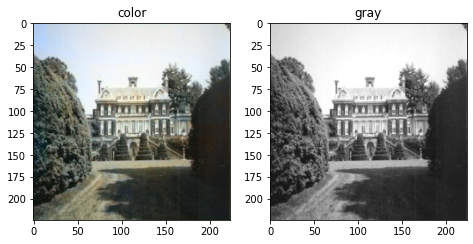

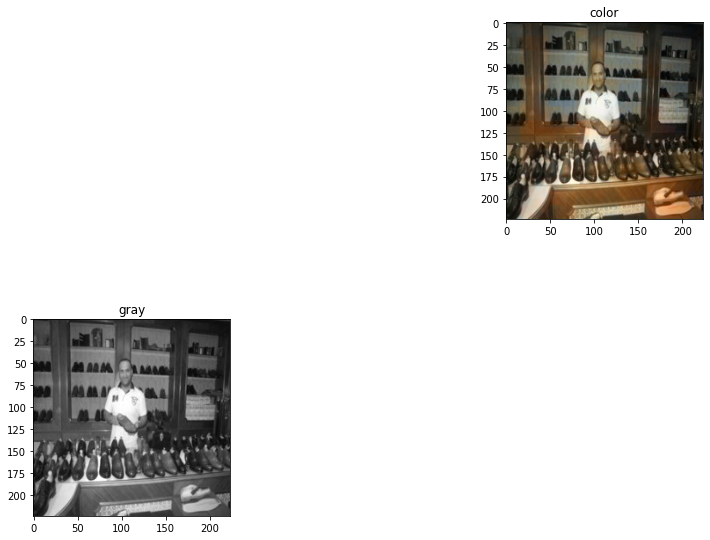

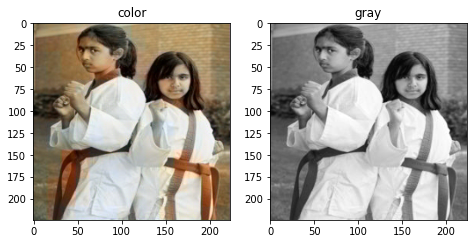

Average Loss= 0.031979
testing average costs=0.12697571516036987
Average Loss= 0.033077
testing average costs=0.12986361980438232
Average Loss= 0.032306
testing average costs=0.11829143762588501
Average Loss= 0.031433
testing average costs=0.12654775381088257
Average Loss= 0.029285
testing average costs=0.12071060389280319
Average Loss= 0.031123
testing average costs=0.12226980179548264
Average Loss= 0.028294
testing average costs=0.12392249703407288
Average Loss= 0.028427
testing average costs=0.12286851555109024
Average Loss= 0.026857
testing average costs=0.12247837334871292


In [26]:


if(__name__=="__main__"):
   
    plt.rcParams['figure.figsize'] = [12, 10]
    
    root_dir = "/content/drive/MyDrive/"
    output_dir = os.path.join(root_dir, "output")
    img_dir = "/content/drive/MyDrive/places365"
    annotation_csv_file = "/content/drive/MyDrive/places365.csv"
    annotation_csv_test_file = "/content/drive/MyDrive/places365_test.csv"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # ResidualModel : 0, TransferModel : 1
    config = {
              "mode": "train",
              "which_network" : 1,
              "model_name":"epoch_{0:d}.pt".format(30),
              "output_dir":output_dir,
              "img_dir": img_dir,
              "annotation_csv_file" : annotation_csv_file,
              "annotation_csv_test_file" : annotation_csv_test_file,
              "learning_rate":0.0001,
              "batch_size":8,
              "epoch":40,
              }

    if(config["mode"] == "train"):
        loss_train, loss_test = train(config)
    else:
        test(config)

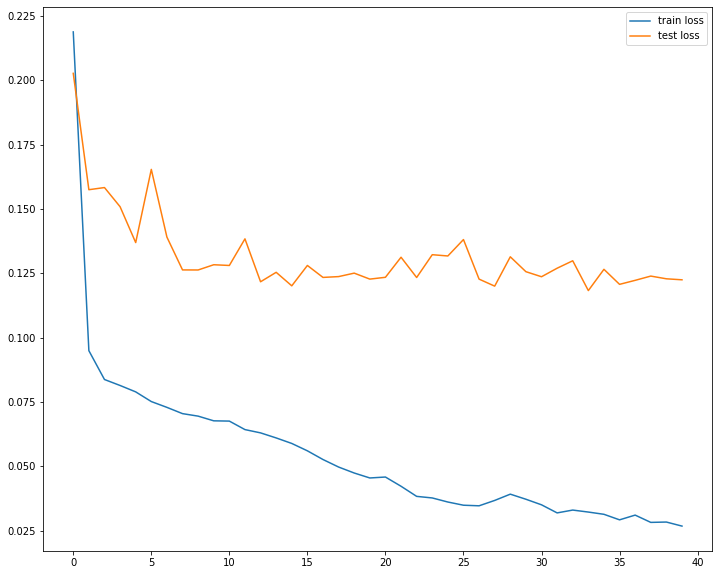

In [27]:

plt.plot(loss_train, label="train loss")
plt.plot(loss_test, label= "test loss")
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


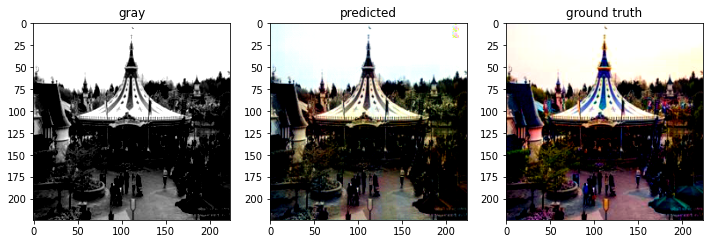

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


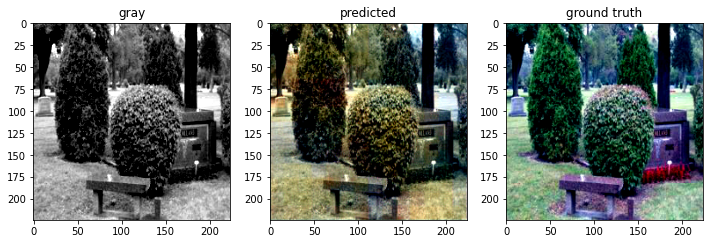

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


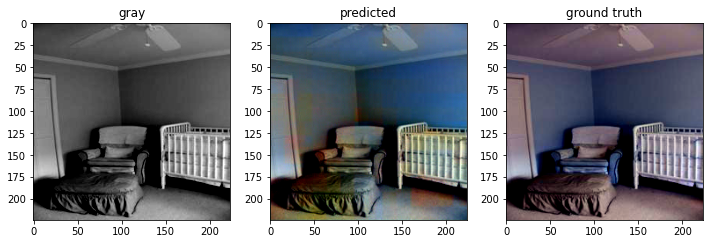

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


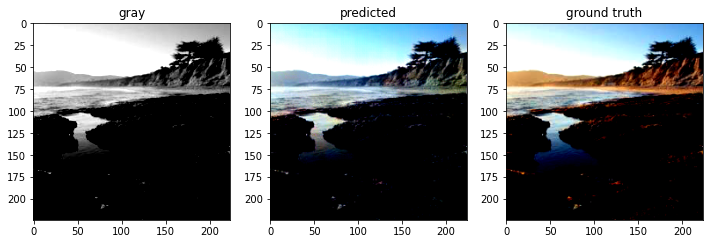

testing average PSNR=16.68070411682129
testing average costs=0.1213373988866806


tensor(0.1213, device='cuda:0')

In [49]:
plt.rcParams['figure.figsize'] = [12, 10]
    
root_dir = "/content/drive/MyDrive/"
output_dir = os.path.join(root_dir, "output")
img_dir = "/content/drive/MyDrive/places365"
annotation_csv_file = "/content/drive/MyDrive/places365.csv"
annotation_csv_test_file = "/content/drive/MyDrive/places365_test.csv"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ResidualModel : 0, TransferModel : 1
config = {
          "mode": "test",
          "which_network" : 1,
          "model_name":"epoch_{0:d}.pt".format(39),
          "output_dir":output_dir,
          "img_dir": img_dir,
          "annotation_csv_file" : annotation_csv_file,
          "annotation_csv_test_file" : annotation_csv_test_file,
          "learning_rate":0.0001,
          "batch_size":8,
          "epoch":30,
          }

test(config)

## ResidualModel training & test result

Average Loss= 468.580948


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


testing average costs=709.8543701171875


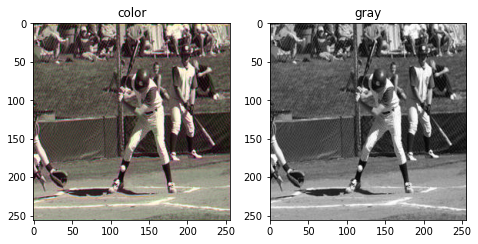

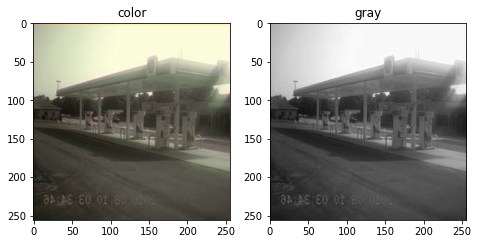

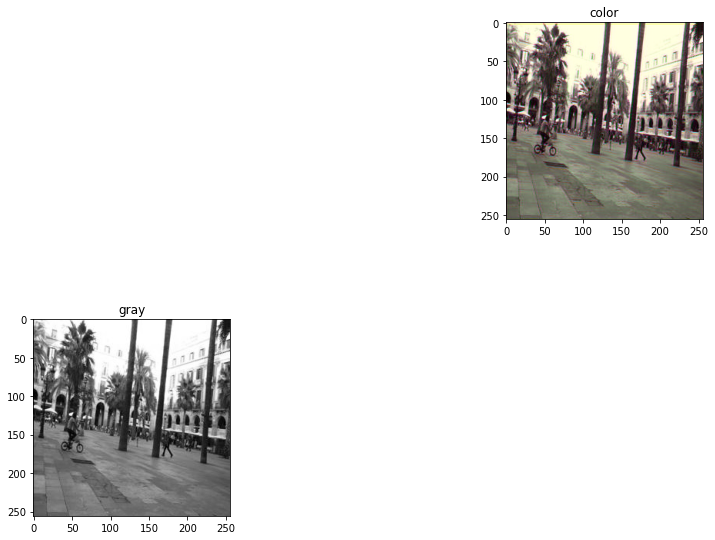

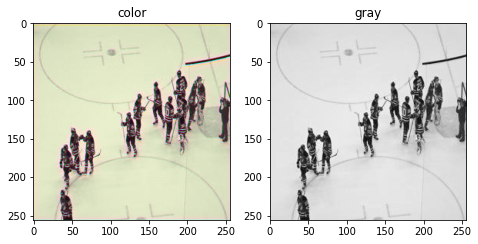

Average Loss= 314.267836
testing average costs=519.9553833007812
Average Loss= 270.646479
testing average costs=480.229736328125
Average Loss= 264.173777
testing average costs=459.2375183105469
Average Loss= 256.342864
testing average costs=465.3006591796875
Average Loss= 248.738671
testing average costs=447.4342956542969
Average Loss= 244.562223
testing average costs=433.64935302734375
Average Loss= 243.673914
testing average costs=470.20025634765625
Average Loss= 235.149121
testing average costs=439.4654846191406
Average Loss= 235.284829
testing average costs=414.7494201660156
Average Loss= 230.337846


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


testing average costs=437.3841857910156


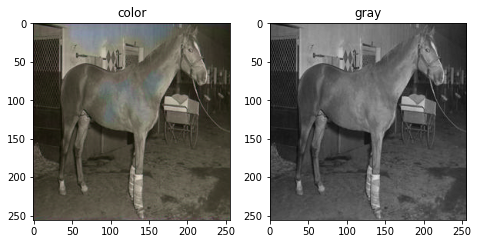

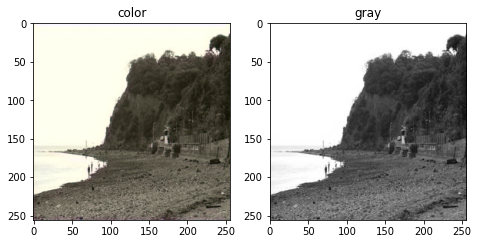

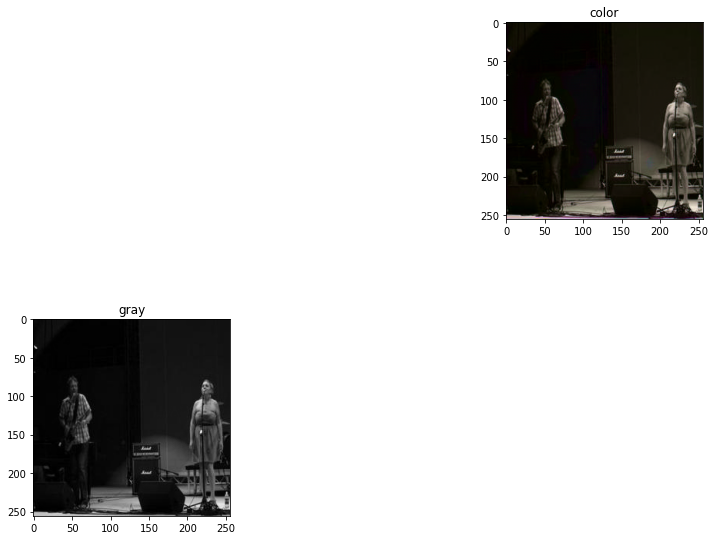

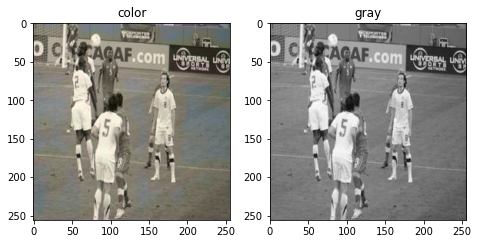

Average Loss= 236.506615
testing average costs=410.7674560546875
Average Loss= 232.838162
testing average costs=424.3755187988281
Average Loss= 242.955665
testing average costs=405.7922058105469
Average Loss= 231.147655
testing average costs=450.64337158203125
Average Loss= 231.253554
testing average costs=409.2525634765625
Average Loss= 225.315865
testing average costs=407.6012878417969
Average Loss= 225.935962
testing average costs=397.3230285644531
Average Loss= 230.422818
testing average costs=434.7506408691406
Average Loss= 228.205553
testing average costs=433.25494384765625
Average Loss= 223.787341


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


testing average costs=399.3215026855469


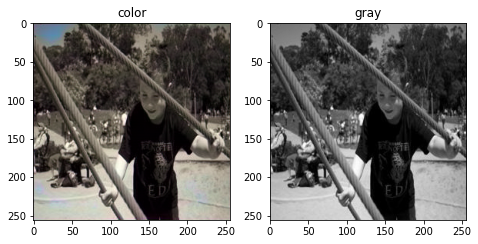

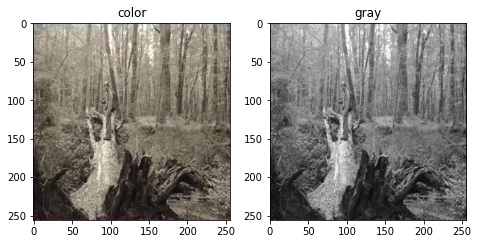

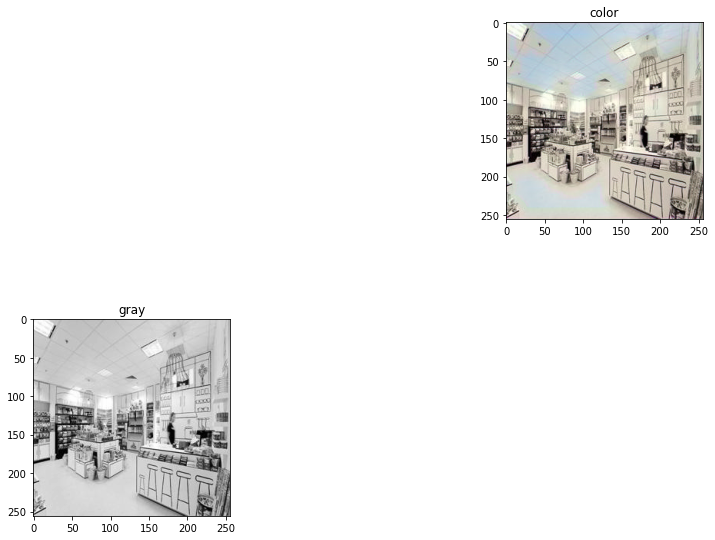

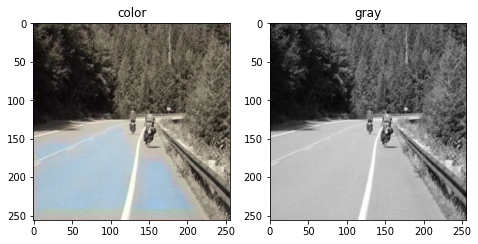

Average Loss= 230.218371
testing average costs=429.9303894042969
Average Loss= 217.088445
testing average costs=409.53460693359375
Average Loss= 217.395748
testing average costs=396.4864807128906
Average Loss= 217.361985
testing average costs=401.5158996582031
Average Loss= 220.071913
testing average costs=396.6220397949219
Average Loss= 214.168938
testing average costs=393.7391357421875
Average Loss= 218.105663
testing average costs=395.7370910644531
Average Loss= 212.741381
testing average costs=398.1739501953125
Average Loss= 213.795244
testing average costs=404.43292236328125
Average Loss= 214.214707


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


testing average costs=420.6940612792969


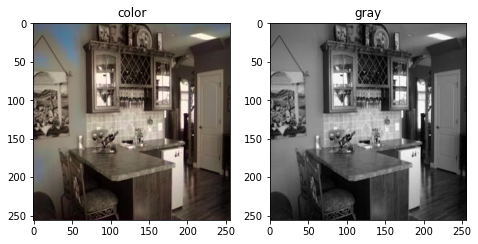

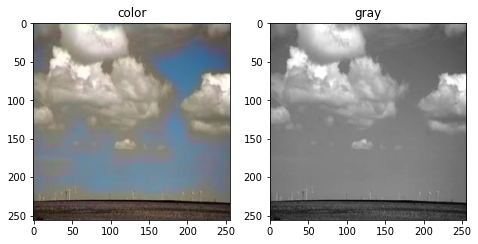

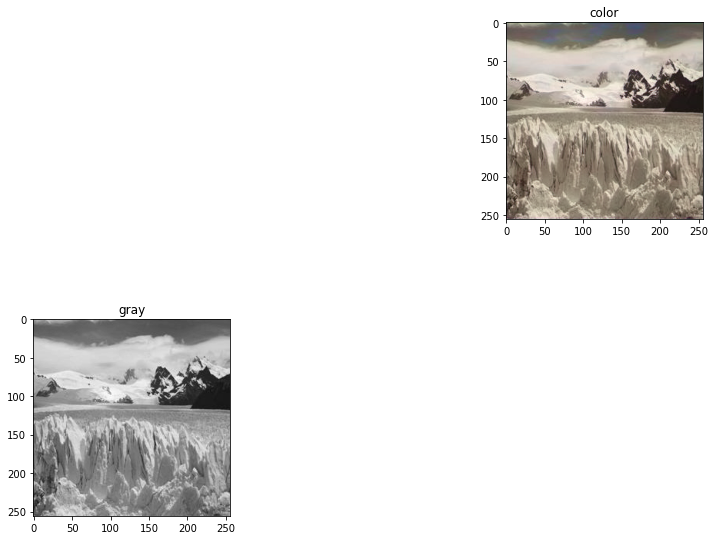

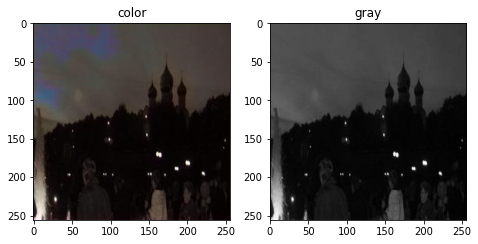

Average Loss= 214.177932
testing average costs=422.1911315917969
Average Loss= 213.543197
testing average costs=392.68353271484375
Average Loss= 211.900214
testing average costs=392.2050476074219
Average Loss= 212.955987
testing average costs=389.0694274902344
Average Loss= 216.890321
testing average costs=400.15264892578125
Average Loss= 212.123980
testing average costs=389.5718994140625
Average Loss= 211.209621
testing average costs=403.9852600097656
Average Loss= 209.982516
testing average costs=401.4571228027344
Average Loss= 211.490353
testing average costs=393.69036865234375


In [30]:
if(__name__=="__main__"):
  plt.rcParams['figure.figsize'] = [12, 10]
      
  root_dir = "/content/drive/MyDrive"
  output_dir = os.path.join(root_dir, "output_residual")
  img_dir = "/content/drive/MyDrive/places365"
  annotation_csv_file = "/content/drive/MyDrive/places365.csv"
  annotation_csv_test_file = "/content/drive/MyDrive/places365_test.csv"
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  # ResidualModel : 0, TransferModel : 1
  config = {
            "mode": "train",
            "which_network" : 0,
            "model_name":"epoch_{0:d}.pt".format(50),
            "output_dir":output_dir,
            "img_dir": img_dir,
            "annotation_csv_file" : annotation_csv_file,
            "annotation_csv_test_file" : annotation_csv_test_file,
            "learning_rate":0.0001,
            "batch_size":8,
            "epoch":40,
            }

  loss_train, loss_test = train(config)

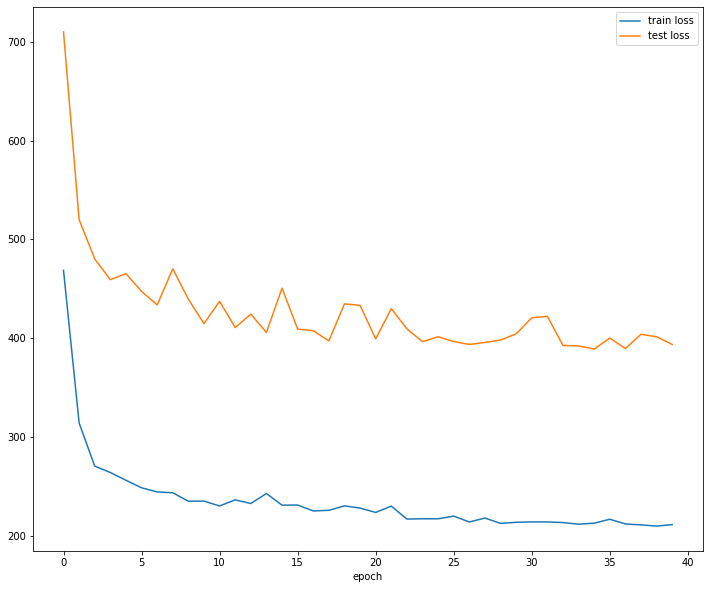

In [32]:

plt.plot(loss_train, label="train loss")
plt.plot(loss_test, label= "test loss")
plt.xlabel("epoch")
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


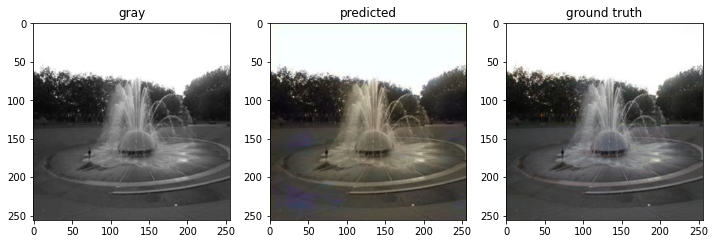

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


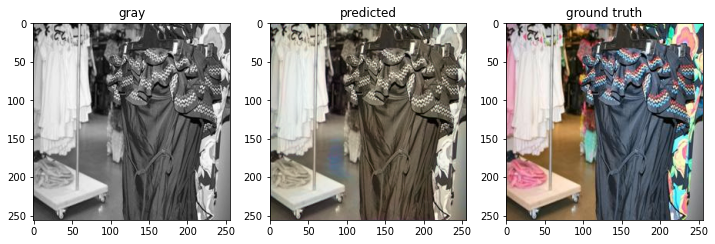

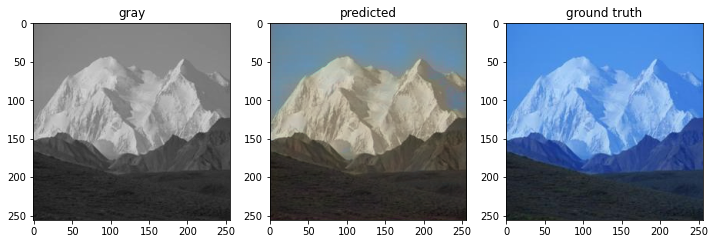

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


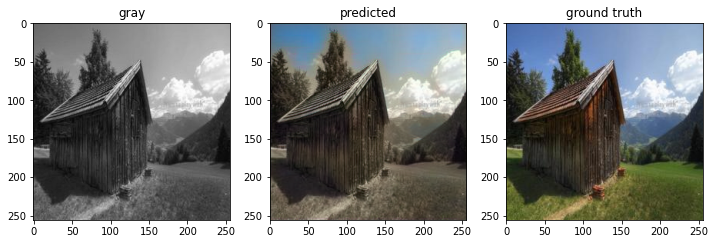

testing average PSNR=22.50495147705078
testing average costs=403.4381103515625


In [43]:
if(__name__=="__main__"):
  plt.rcParams['figure.figsize'] = [12, 10]
      
  root_dir = "/content/drive/MyDrive"
  output_dir = os.path.join(root_dir, "output_residual")
  img_dir = "/content/drive/MyDrive/places365"
  annotation_csv_file = "/content/drive/MyDrive/places365.csv"
  annotation_csv_test_file = "/content/drive/MyDrive/places365_test.csv"
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  # ResidualModel : 0, TransferModel : 1
  config = {
            "mode": "test",
            "which_network" : 0,
            "model_name":"epoch_{0:d}.pt".format(39),
            "output_dir":output_dir,
            "img_dir": img_dir,
            "annotation_csv_file" : annotation_csv_file,
            "annotation_csv_test_file" : annotation_csv_test_file,
            "learning_rate":0.00007,
            "batch_size":8,
            "epoch":30,
            }

  test(config)